# Import Packages

In [1]:
import os
import random
import cv2
import random
from PIL import Image
import tifffile as tiff
import models_pytorch
import losses_pytorch
import imageio as io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import defaultdict 


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from skimage.morphology import binary_dilation, binary_erosion
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.metrics import average_precision_score

import albumentations as A
import albumentations.augmentations.functional as FA
from albumentations.pytorch import ToTensorV2

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Losses

## VGG Loss Setup

In [3]:
model = models.vgg19(pretrained=True, progress=True)
# print(model)

In [4]:
conv_layers = []
model_children = list(model.children())[0].to(device)

In [5]:
idx = 0
conv_idx = []
for child in model_children:
    if type(child)==nn.ReLU: 
        conv_layers.append(child.to(device))
        conv_idx.append(idx)
    idx+=1

In [6]:
for i in conv_idx:
    print((model_children[i]))

ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)


In [7]:
class top_loss(nn.Module):
    def __init__(self, conv_idx, multiplier=1):
        super(top_loss, self).__init__()
        self.smooth    = 1
        self.conv_idx  = conv_idx
        self.multiplier = multiplier
    def forward(self, y_pred, y_true):
        
        y_true = torch.cat([y_true,y_true,y_true],dim=1)
        y_pred = torch.cat([y_pred,y_pred,y_pred],dim=1)
        
        #ground truth feature maps
        #feature maps for the first layer
        results_true = [model_children[0](y_true)]
        results_pred = [model_children[0](y_pred)]
        
        for i in range(1, len(model_children)):
            x = model_children[i](results_true[-1])
            y = model_children[i](results_pred[-1])
            results_true.append(x)
            results_pred.append(y)
        
        loss = 0
        for i in self.conv_idx:
            x = results_true[i]
            y = results_pred[i]

            #difference in each feature map of GT and Pred
            z = (1/(x.shape[0]*x.shape[1]*x.shape[2]*x.shape[3]))*((torch.linalg.norm(x-y))**2)#add to list
            #cumulative difference of all the feature maps
            loss+= z
        loss = self.multiplier*loss
        
        return loss

## Border Loss

In [8]:
def weighted_bce_loss(output,y,weight):
    epsilon= 1e-7
    output = torch.clamp(output, epsilon, 1.-epsilon)
    logit_output = torch.log(output/(1.-output))
    
    loss = (1.-y)*logit_output + (1.+(weight-1.)*y) * (torch.log(1.+torch.exp(-torch.abs(logit_output))) + torch.maximum(-logit_output,torch.tensor(0.).cuda()))
    return torch.sum(loss)/torch.sum(weight)

def weighted_dice_loss(output,y,weight):
    smooth = 1.
    w,m1,m2 = weight*weight, y, output
    intersection = (m1*m2)
    score = (2.*torch.sum(w*intersection)+smooth)/(torch.sum(w*m1)+torch.sum(w*m2)+smooth)
    loss  = 1.-torch.sum(score)
    return loss

def border_loss(output,y,pool_size=(11,11), pad=(5,5)):
    y      = y.type(torch.float32)
    output = output.type(torch.float32)
    
    averaged_mask = F.avg_pool2d(y,kernel_size=pool_size,stride=(1,1), padding=pad)
    border = (averaged_mask>0.005).type(torch.float32) * (averaged_mask<0.995).type(torch.float32)
    weight = torch.ones_like(averaged_mask)
    w0     = torch.sum(weight)
    weight+= border*2
    w1     = torch.sum(weight)
    weight*= (w0/w1)
    loss   = weighted_bce_loss(output,y,weight) + weighted_dice_loss(output,y,weight)
    return loss

## Initialize Losses

In [9]:
def weighted_bce_loss(output,y,weight):
    epsilon= 1e-7
    output = torch.clamp(output, epsilon, 1.-epsilon)
    logit_output = torch.log(output/(1.-output))
    
    loss = (1.-y)*logit_output + (1.+(weight-1.)*y) * (torch.log(1.+torch.exp(-torch.abs(logit_output))) + torch.maximum(-logit_output,torch.tensor(0.).cuda()))
    return torch.sum(loss)/torch.sum(weight)

def weighted_dice_loss(output,y,weight):
    smooth = 1.
    w,m1,m2 = weight*weight, y, output
    intersection = (m1*m2)
    score = (2.*torch.sum(w*intersection)+smooth)/(torch.sum(w*m1)+torch.sum(w*m2)+smooth)
    loss  = 1.-torch.sum(score)
    return loss

def border_loss(output,y,pool_size=(9,9), pad=(4,4)):
    y      = y.type(torch.float32)
    output = output.type(torch.float32)
    
    averaged_mask = F.avg_pool2d(y,kernel_size=pool_size,stride=(1,1), padding=pad)
    border = (averaged_mask>0.005).type(torch.float32) * (averaged_mask<0.995).type(torch.float32)
    weight = torch.ones_like(averaged_mask)
    w0     = torch.sum(weight)
    weight+= border*2
    w1     = torch.sum(weight)
    weight*= (w0/w1)
    loss   = weighted_bce_loss(output,y,weight) + weighted_dice_loss(output,y,weight)
    return loss


class IoULoss(nn.Module):
    
    def __init__(self):
        super(IoULoss, self).__init__()
        self.smooth = 1
        
    def forward(self, y_pred, y_true, weight):
        weight = weight*weight
        intersection = y_true*y_pred
        not_true     = 1 - y_true
        union        = y_true + (not_true * y_pred)
        iou         = (torch.sum(intersection*weight)) / (torch.sum(union*weight))

        loss = 1-iou
        return loss
    
iou_loss = IoULoss()

In [10]:
dice_loss = losses_pytorch.DiceLoss()
bce_loss  = torch.nn.BCELoss()
IoU_loss  = losses_pytorch.IoULoss()
wbce_loss = losses_pytorch.wbce()
vgg_loss  = top_loss(conv_idx=[conv_idx[1]])

# Functions

In [11]:
################ Metrics #######################
def IoU_pr_rec_f1(y_true, y_pred):
    
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    y_pred = ((y_pred)*1.).type(torch.float32)
    
    tp = torch.sum(y_true*(y_pred))
    tn = torch.sum((1-y_true)*((1-y_pred)))
    fp = torch.sum((1-y_true)*(y_pred))
    fn = torch.sum((y_true)*((1-y_pred)))
    
    pr  = (tp/(tp+fp))
    rec = (tp/(tp+fn))
    f1  = ((2*pr*rec)/(pr+rec))
    tnr = (tn/(tn+fp))
    fpr = (fp/(fp+tn))
    
    intersection = y_true*y_pred
    not_true     = 1 - y_true
    union        = y_true + (not_true * y_pred)
    iou         = (torch.sum(intersection)) / (torch.sum(union))
    
    return iou, pr, rec, f1, tnr, fpr

# Saving Metrics
def metrics():
    x = np.arange(0,1,0.05)
    IoU_      = []
    threshold = []
    precision = []
    recall    = []
    F_score   = []
    mF_score  = []
    TNR       = []
    FPR       = []
    name_list = []

    dict_1 = {'Name':name_list,
              'Precision':precision,
              'Recall':recall,
              'IoU':IoU_,
              'F-Score':F_score,
              'mF-Score':mF_score,
              'Threshold': threshold,
              'True Negative Rate':TNR,
              'False Positive Rate':FPR}
    return dict_1

def best_f_score(name, test_masks, predictions) :
    dict_1 = metrics()
    y = 0
    outer = 0
    check = 0
    x = 0 
    y = 1
    while outer<3:    
        if y>1:
            m = y-1
            y-= m
        z = np.linspace(x, y, 21)
        for i in z:
#             print(i)
            y_true = torch.from_numpy(test_masks)
            y_pred = torch.from_numpy((predictions>i)*1)

            tp = torch.sum(y_true*(y_pred),dim=[1,2,3])
            tn = torch.sum((1-y_true)*((1-y_pred)),dim=[1,2,3])
            fp = torch.sum((1-y_true)*(y_pred),dim=[1,2,3])
            fn = torch.sum((y_true)*((1-y_pred)),dim=[1,2,3])

            pr  = (tp/(tp+fp))
            rec = (tp/(tp+fn))
            score  = ((2*pr*rec)/(pr+rec))
            idx    = torch.isnan(score)
            score[idx] = 0
            score  = torch.sum(score)/len(X_test)
            
            a,b,c,d,e,f = IoU_pr_rec_f1(torch.from_numpy(test_masks), torch.from_numpy(predictions>i))
            dict_1['IoU'].append(a.numpy())
            dict_1['Threshold'].append(i)
            dict_1['Precision'].append(b.numpy())
            dict_1['Recall'].append(c.numpy())
            dict_1['F-Score'].append(d.numpy())
            dict_1['mF-Score'].append(score.cpu().detach().numpy())
            dict_1['True Negative Rate'].append(e.numpy())
            dict_1['False Positive Rate'].append(f.numpy())
            dict_1['Name'].append(name)
            if d>check:
                check = d
                x = i
            else:
                pass
        if outer == 0:
            y = x+0.1
        elif outer==1:
            y = x+0.01
        outer+=1
    
    df = pd.DataFrame(dict_1)
    df = df.sort_values(by=['F-Score'], ascending=False)
    df = df.iloc[0:1]
    
    AP = average_precision_score(test_masks.reshape(-1), predictions.reshape(-1))
    df['AP'] = AP
        
    return df

dict_1 = metrics()

In [12]:
################ Metadata ########################
def metadata(Y):
    list_ = defaultdict(list)
    for i in range(len(Y)):
        water = (Y[i].sum()/np.prod(Y[i].shape))*100
        list_[f'Image_{i}'].append(water)
        list_[f'Image_{i}'].append(100-water)
    for i in range(len(Y)):
        water = (Y[i].sum()/np.prod(Y[i].shape))*100
        if water>90:
            list_[f'Image_{i}'].append(1)
        else:
            list_[f'Image_{i}'].append(0)
    for i in range(len(Y)):
        water = (Y[i].sum()/np.prod(Y[i].shape))*100
        if water<10:
            list_[f'Image_{i}'].append(1)
        else:
            list_[f'Image_{i}'].append(0)
    return list_

def water_percentages(df_meta):
    water_p = df_meta[0].values
    indices = np.arange(len(water_p))
    dict_idx = {}
    limit = 10
    for i in range(12):
        if i==0:
            idx = np.where(water_p<1)
            dict_idx[f'Index=0'] = indices[idx[0]]
            water_p = np.delete(water_p, idx)
            indices = np.delete(indices, idx)
        elif i==11:
            idx = np.where(water_p>99)
            dict_idx[f'Index=100'] = indices[idx[0]]
            water_p = np.delete(water_p, idx)
            indices = np.delete(indices, idx)
        else:
            idx = np.where(water_p<limit)
            dict_idx[f'Index_{limit}'] = indices[idx[0]]
            water_p = np.delete(water_p, idx)
            indices = np.delete(indices, idx)
            if limit<90:
                limit+=10
            else:
                limit+=9
            
    return dict_idx

def list_test(dict_idx):
    counter = 0
    list_ = []
    dict_ ={}
    lower = 0
    upper = 10
    for key in dict_idx.keys():

        print(f'{key}:',len(dict_idx[key]))
        counter+=len(dict_idx[key])
        dict_['Water'+key.split('Index')[-1]] = [len(dict_idx[key]), len(dict_idx[key])/2053*100]
        list_.append(list(dict_idx[key]))
        lower+=10
        upper+=10
    print(f'Total Images: {counter}')
    print('-'*10)
    print()
    
    
    return list_

In [13]:
############## IOU for Train Time Display 0.5 Threshold ##################
def IoU(y_true, y_pred, threshold=0.5):
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)
    y_pred = ((y_pred>threshold)*1.).type(torch.float32)
    
    intersection = y_true*y_pred
    not_true     = 1 - y_true
    union        = y_true + (not_true * y_pred)
    iou         = (torch.sum(intersection)) / (torch.sum(union))
    
    return iou

In [14]:
############## F1 for Train Time Display 0.5 Threshold ##################
def f1_score(y_pred, y_true, threshold=0.5):
    
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)
    y_pred = ((y_pred>threshold)*1.).type(torch.float32)
    
    tp = torch.sum(y_true*(y_pred))
    tn = torch.sum((1-y_true)*((1-y_pred)))
    fp = torch.sum((1-y_true)*(y_pred))
    fn = torch.sum((y_true)*((1-y_pred)))
    
    pr  = ((tp+1.)/(tp+fp+1.))
    rec = ((tp+1.)/(tp+fn+1.))
    f1  = ((2*pr*rec)/(pr+rec))
    return f1

# Load Data

In [15]:
X_train = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_train_4500_30m_res.npy")
X_val   = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_val_500_30m_res.npy")
X_test  = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_test_2000_30m_res.npy")

Y_train         = (X_train[...,1]-X_train[...,3])/(X_train[...,1]+X_train[...,3])
Y_val           = (X_val[...,1]-X_val[...,3])/(X_val[...,1]+X_val[...,3])
Y_test          = (X_test[...,1]-X_test[...,3])/(X_test[...,1]+X_test[...,3])

Y_train         = ((Y_train<1.)*1).astype('float32')
Y_val           = ((Y_val<1.)*1).astype('float32')
Y_test          = ((Y_test<1.)*1).astype('float32')


X_train         = X_train[...,2::-1].copy()
X_val           = X_val[...,2::-1].copy()
X_test          = X_test[...,2::-1].copy()

X_train         = X_train>>4
X_val           = X_val>>4
X_test          = X_test>>4

X_train         = X_train/1024.
X_val           = X_val/1024.
X_test          = X_test/1024.

# X_train         = X_train - X_train.min(axis=(1,2), keepdims=True) 
# X_val           = X_val  - X_val.min(axis=(1,2), keepdims=True)
# X_test          = X_test - X_test.min(axis=(1,2), keepdims=True) 

# X_train         = X_train / X_train.max(axis=(1,2), keepdims=True) 
# X_val           = X_val  / X_val.max(axis=(1,2), keepdims=True)
# X_test          = X_test / X_test.max(axis=(1,2), keepdims=True) 

C:\Users\SMOHA\AppData\Local\Temp/ipykernel_14656/4030842833.py:5: RuntimeWarning: invalid value encountered in true_divide
  Y_train         = (X_train[...,1]-X_train[...,3])/(X_train[...,1]+X_train[...,3])
C:\Users\SMOHA\AppData\Local\Temp/ipykernel_14656/4030842833.py:7: RuntimeWarning: invalid value encountered in true_divide
  Y_test          = (X_test[...,1]-X_test[...,3])/(X_test[...,1]+X_test[...,3])


In [16]:
#Get Metadata Sentinel
df = metadata(Y_train)
df_meta_train = pd.DataFrame.from_dict(df,orient='index')
print('Test Images:',len(df_meta_train))

#Get Metadata Landsat
df = metadata(Y_test)
df_meta_test = pd.DataFrame.from_dict(df,orient='index')
print('Test Images:',len(df_meta_test))

Test Images: 4500
Test Images: 2000


In [17]:
water_p_train = water_percentages(df_meta_train)
water_p_test = water_percentages(df_meta_test)

list_test_train = list_test(water_p_train)
list_test_test = list_test(water_p_test)

Index=0: 0
Index_10: 138
Index_20: 509
Index_30: 450
Index_40: 414
Index_50: 304
Index_60: 381
Index_70: 365
Index_80: 379
Index_90: 483
Index_99: 1077
Index=100: 0
Total Images: 4500
----------

Index=0: 0
Index_10: 59
Index_20: 215
Index_30: 204
Index_40: 185
Index_50: 149
Index_60: 173
Index_70: 181
Index_80: 155
Index_90: 199
Index_99: 480
Index=100: 0
Total Images: 2000
----------



In [18]:
# ################ Get Contours ##########################
# Y_train = np.array([binary_dilation(mask)-mask for mask in Y_train ], dtype='float64')
# Y_val   = np.array([binary_dilation(mask)-mask for mask in Y_val], dtype='float64')
# Y_test  = np.array([binary_dilation(mask)-mask for mask in Y_test], dtype='float64')

# Pytorch DataLoaders

In [19]:
class NDWIDataset(Dataset):

    def __init__(self, images, masks, transform=None, test_transform=None):
        self.images     = images
        self.masks      = masks
        self.transforms = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transforms:
            augmentations = self.transforms(image=image, mask=mask)
        
        image = augmentations['image']
        mask  = augmentations['mask']
        mask  = mask[np.newaxis,:,:]
        
        return [image.type(torch.float32), 
                mask.type(torch.float32)]
        

In [20]:
def data(trans, trans_test, X_train, Y_train, X_val, Y_val, X_test, Y_test, split=0.9, val=True, batch_size=16):
    torch.manual_seed(49)
    random.seed(49)
    trainset= NDWIDataset(X_train, Y_train, transform=trans)

    if val:
        print(f'Training:{len(X_train)}, Validation:{len(X_val)}')
        print(f'Testing: {len(X_test)}')
        
        valset  = NDWIDataset(X_val, Y_val, transform=trans_test)
        testset = NDWIDataset(X_test, Y_test, transform=trans_test)
        image_datasets = {'train': trainset, 'val': valset, 'test': testset}
        batch_size = batch_size

        dataloaders = {
          'train': DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True, drop_last=True),#, num_workers=8),
          'val': DataLoader(valset, batch_size=batch_size, shuffle=True, pin_memory = True, drop_last=True),#, num_workers=8),
          'test': DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory = True, drop_last=True)#, num_workers=8)
        }
        
    else:
        print(f'Training:{len(X_train)}')
        print(f'Testing: {len(X_test)}')
        testset = NDWIDataset(X_test, Y_test, transform=trans_test)
        image_datasets = {'train': trainset, 'test': testset}
        batch_size = batch_size

        dataloaders = {
          'train': DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'test': DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory = True)#, num_workers=8)
        }
        
    
    return dataloaders

In [21]:
trans = A.Compose([
    ToTensorV2()])
trans_test = A.Compose([
             ToTensorV2()])

In [22]:
def plot_rand(dataloader, set_='train'):
    if set_==None:
        for x,y in dataloader:
            x,y = x.numpy().transpose([0,2,3,1]), y.numpy().squeeze()
            break
    else:
        for x,y in dataloader[set_]:
            x,y = x.numpy().transpose([0,2,3,1]), y.numpy().squeeze()
            break
    rand = np.random.randint(0,x.shape[0])
    plt.subplot(121)
    plt.imshow(x[rand])
    plt.title('Image')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(y[rand])
    plt.title('Contour')
    plt.axis('off')
    plt.show()

# Train Function

In [23]:
import time
def train(model, dataloaders, loss_fn, optimizer, acc_fn, random_state=49, epochs=1):
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    start = time.time()                                        #Initialize time to calculate time it takes to train model
    model.to(device)                                               #Move model to GPU     

    counter=0
    train_loss, valid_loss = [], []                            #Running training and validation loss
    val_epoch, f1_epoch = [0],[0]
    loss_list = []
    times     = []
#     epoch = 1
    for epoch in range(epochs):
        start_epoch = time.time()
        print(f'Epoch {epoch+1}')
        print(scheduler.get_last_lr())
    

    #########################################Begin Model Training######################################################
    ###################################################################################################################
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()                             # Set training mode all the layers including batchnorm and dropout work in this
                dataloader = dataloaders['train']         #get the training data
            else:
                model.eval()                              # Set model to evaluate mode deactivates the batchnorm and dropout layers
                dataloader = dataloaders['val']           #get the validation data

            running_loss = 0.0                            #running loss to be used for visualization later
            step = 0                                      #Batch number
            
            if phase == 'train':  
                f1 = []
                for inputs, labels in dataloader:
                    x, y = inputs.to(device), labels.to(device)
                    step += 1

                    optimizer.zero_grad()                                   # zero the gradients
                    outputs = model(x)                                      #get model output for a given input

                    #################Metrics###################
                    f1.append(acc_fn(outputs, y).cpu().detach().numpy())
                    ############################################

                    ##################Calculate Loss, backprop, and update###############
                    loss           = loss_fn(outputs, y)
                    train_loss.append(loss.cpu().detach().numpy())
                    loss.backward()
                    optimizer.step()
                    print(f'Current step: {step}, AllocMem (Mb): {torch.cuda.memory_allocated()/1024/1024:.3f}, Loss: {loss:.3f},  F1: {np.mean(f1):.3f}', end='\r') 
                    ######################################################################
        
            else:  
                loss_val = []
                f1=[]
                with torch.no_grad():
                    for inputs, labels in dataloader:
                        x, y = inputs.to(device), labels.to(device)
                        optimizer.zero_grad()                                   # zero the gradients
                        outputs = model(x)                                      #get model output for a given input

                        #################Metrics###################
                        f1.append(acc_fn(outputs, y).cpu().detach().numpy())
                        ############################################

                        ##################Calculate Loss, backprop, and update###############
                        valid_loss.append(loss_fn(outputs, y).cpu().detach().numpy())
                        loss_val.append(valid_loss[-1])
                val_epoch.append(np.mean(loss_val))
                f1_epoch.append(np.mean(f1))
                print()
                print()
                print(f' Loss val: {val_epoch[-1]:.3f}, F-Score val:{f1_epoch[-1]:.3f} \n') 
                ######################################################################
                
                ##### Check validation #####
#                 if f1_epoch[-1] > f1_epoch[-2]:
#                     counter = 0
#                     print('Counter Reset')
#                 else:
#                     counter+=1
#                     print(f'Counter is {counter}')

            print()
            time_elapsed = time.time() - start_epoch
            times.append(time_elapsed)
            print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
            print('-' * 10)      

        scheduler.step()
#         torch.save(model, path+ '\\' + f'Epcoh_{str(epoch).zfill(3)}'+ '.pth')
        epoch+=1
    #########################################End Model Training######################################################
    ###################################################################################################################
    
    #Total training time including time to test
    time_elapsed = time.time() - start
    print('\n Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return {'Train Loss':train_loss,
            'Valid Loss':valid_loss,
            'Times'     :times,
            'Epochs'    : epoch+1}

## Prediction Function

In [24]:
def test_pred(model,X_test,batch_size=32):
    model.eval()
    if model.training==True:
        raise ValueError('Model is in training mode')
    else:
        pass
    
    predictions = np.zeros([len(X_test),1,X_test.shape[1],X_test.shape[2]])
    i = 0
    for x, y in tqdm(dataloaders['test']):
        predictions[i:i+batch_size] = model(x.cuda()).cpu().detach().numpy()
        i+=batch_size
    return predictions

# MultiScale2

In [25]:
class basic_block(nn.Module):
    def __init__(self,in_channels,out_channels, random_state=0):
        super(basic_block,self).__init__()
        torch.manual_seed(random_state)
        self.bn1         = nn.BatchNorm2d(in_channels)
        self.conv1x1_1_1 = nn.Conv2d(in_channels, out_channels, 1)
        self.bn2         = nn.BatchNorm2d(out_channels)
        self.conv1x1_1_3 = nn.Conv2d(in_channels, out_channels, 1)
        self.bn3         = nn.BatchNorm2d(out_channels)
        self.conv3x3_1   = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn4         = nn.BatchNorm2d(out_channels)
        self.conv1x1_1_5 = nn.Conv2d(in_channels, out_channels, 1)
        self.bn5         = nn.BatchNorm2d(out_channels)
        self.conv5x5_1   = nn.Conv2d(out_channels,out_channels,5,padding=2)
        self.bn6         = nn.BatchNorm2d(out_channels)
        self.conv1x1_1_7 = nn.Conv2d(in_channels, out_channels, 1)
        self.bn7         = nn.BatchNorm2d(out_channels)
        self.conv7x7_1   = nn.Conv2d(out_channels,out_channels,7,padding=3)
        self.bn8         = nn.BatchNorm2d(out_channels)
        
        self.bn9         = nn.BatchNorm2d(out_channels*4)
        self.conv1x1_2_1 = nn.Conv2d(out_channels*4, out_channels, 1)
        self.bn10        = nn.BatchNorm2d(out_channels)
        self.conv1x1_2_3 = nn.Conv2d(out_channels*4, out_channels, 1)
        self.bn11        = nn.BatchNorm2d(out_channels)
        self.conv3x3_2   = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn12        = nn.BatchNorm2d(out_channels)
        self.conv1x1_2_5 = nn.Conv2d(out_channels*4, out_channels, 1)
        self.bn13        = nn.BatchNorm2d(out_channels)
        self.conv5x5_2   = nn.Conv2d(out_channels,out_channels,5,padding=2)
        self.bn14        = nn.BatchNorm2d(out_channels)
        self.conv1x1_2_7 = nn.Conv2d(out_channels*4, out_channels, 1)
        self.bn15        = nn.BatchNorm2d(out_channels)
        self.conv7x7_2   = nn.Conv2d(out_channels,out_channels,7,padding=3)
        self.bn16        = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        
        bn1         = self.bn1(x)
        conv1x1_1_3 = self.bn3(self.conv1x1_1_3(bn1))
        conv1x1_1_5 = self.bn4(self.conv1x1_1_5(bn1))
        conv1x1_1_7 = self.bn5(self.conv1x1_1_7(bn1))
        conv1x1_1_1 = F.relu(self.bn2(self.conv1x1_1_1(bn1)))
        conv3x3_1   = F.relu(self.bn6(self.conv3x3_1(conv1x1_1_3)))
        conv5x5_1   = F.relu(self.bn7(self.conv5x5_1(conv1x1_1_5)))
        conv7x7_1   = F.relu(self.bn8(self.conv7x7_1(conv1x1_1_7)))
        cat1        = torch.cat([conv1x1_1_1,conv3x3_1,conv5x5_1,conv7x7_1],dim=1)
        
        bn9         = self.bn9(cat1)
        conv1x1_2_3 = self.bn11(self.conv1x1_2_3(bn9))
        conv1x1_2_5 = self.bn12(self.conv1x1_2_5(bn9))
        conv1x1_2_7 = self.bn13(self.conv1x1_2_7(bn9))
        conv1x1_2_1 = F.relu(self.bn10(self.conv1x1_2_1(bn9)))
        conv3x3_2   = F.relu(self.bn14(self.conv3x3_2(conv1x1_2_3)))
        conv5x5_2   = F.relu(self.bn15(self.conv5x5_2(conv1x1_2_5)))
        conv7x7_2   = F.relu(self.bn16(self.conv7x7_2(conv1x1_2_7)))
        cat2        = torch.cat([conv1x1_2_1,conv3x3_2,conv5x5_2,conv7x7_2],dim=1)

        return cat2
        

class UNET_multiscale2(nn.Module):
    def __init__(self, in_channels=3, out_channels= 1, init_features=16, random_state=0):
        super(UNET_multiscale2, self).__init__()
        torch.manual_seed(random_state)
        features = init_features
        self.layer1 =  basic_block(in_channels,16)
        self.down1  = nn.Conv2d(features*4,features,3,padding=1,stride=2)
        
        self.layer2 = basic_block(16,32) 
        self.down2  = nn.Conv2d(features*8,features*2,3,padding=1,stride=2)

        self.layer3 = basic_block(32,64) 
        self.down3  = nn.Conv2d(features*16,features*4,3,padding=1,stride=2)

        self.layer4 = basic_block(64,128)
        self.down4  = nn.Conv2d(features*32,features*8,3,padding=1,stride=2)
        
        self.bottleneck = basic_block(128,256)
        
        self.bn6     = nn.BatchNorm2d(features*16*4)
        self.up1     = nn.ConvTranspose2d(features*16*4, features*8, 3, stride=2, padding=1)
        self.layer6  = basic_block(128*5,128)
        
        self.bn7     = nn.BatchNorm2d(features*8*4)
        self.up2     = nn.ConvTranspose2d(features*8*4, features*4, 3, stride=2, padding=1)
        self.layer7  = basic_block(64*5,64)
        
        self.bn8     = nn.BatchNorm2d(features*4*4)
        self.up3     = nn.ConvTranspose2d(features*4*4, features*2, 3, stride=2, padding=1)
        self.layer8  = basic_block(32*5,32)
        
        self.bn9     = nn.BatchNorm2d(features*2*4)
        self.up4     = nn.ConvTranspose2d(features*2*4, features, 3, stride=2, padding=1)
        self.layer9  = basic_block(16*5,16)
        
        self.out     = nn.Conv2d(features*4, 1, 1)
        
    def forward(self, x):
        
        layer1 = self.layer1(x)
        down1  = F.relu(self.down1(layer1))
        
        layer2 = self.layer2(down1) 
        down2  = F.relu(self.down2(layer2))
        
        layer3 = self.layer3(down2) 
        down3  = F.relu(self.down3(layer3))
        
        layer4 = self.layer4(down3) 
        down4  = F.relu(self.down4(layer4))

        
        bottleneck = self.bottleneck(down4)
        
        up1     = F.relu(self.up1(self.bn6(bottleneck), output_size=layer4.size()))
        merge1  = torch.cat([up1, layer4], dim=1)
        layer6  = self.layer6(merge1)
#         print(up1.shape, layer6.shape, merge1.shape)
        up2        = F.relu(self.up2(self.bn7(layer6), output_size=layer3.size()))
        merge2     = torch.cat([up2, layer3], dim=1)
        layer7     = self.layer7(merge2)
        
        
        up3        = F.relu(self.up3(self.bn8(layer7), output_size=layer2.size()))
        merge3     = torch.cat([up3, layer2], dim=1)
        layer8  = self.layer8(merge3)
        
        up4        = F.relu(self.up4(self.bn9(layer8), output_size=layer1.size()))
        merge4     = torch.cat([up4, layer1], dim=1)
        layer9  = self.layer9(merge4)
                            
        out        = torch.sigmoid(self.out(layer9))
                        
        return out


In [26]:
model = UNET_multiscale2().to(device)
summary(model, (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 3, 128, 128]               6
            Conv2d-2         [-1, 16, 128, 128]              64
       BatchNorm2d-3         [-1, 16, 128, 128]              32
            Conv2d-4         [-1, 16, 128, 128]              64
       BatchNorm2d-5         [-1, 16, 128, 128]              32
            Conv2d-6         [-1, 16, 128, 128]              64
       BatchNorm2d-7         [-1, 16, 128, 128]              32
            Conv2d-8         [-1, 16, 128, 128]              64
       BatchNorm2d-9         [-1, 16, 128, 128]              32
           Conv2d-10         [-1, 16, 128, 128]           2,320
      BatchNorm2d-11         [-1, 16, 128, 128]              32
           Conv2d-12         [-1, 16, 128, 128]           6,416
      BatchNorm2d-13         [-1, 16, 128, 128]              32
           Conv2d-14         [-1, 16, 1

In [35]:
model_dir = r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Results\Water_body"
csv_dir   = r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Results\Water_body\F-score.csv"
dataset   = 'Landsat'

## WBCE + WDice + WIoU

In [28]:
batch_size = 16
dataloaders = data(trans, trans_test, X_train, Y_train, X_val, Y_val, X_test, Y_test, batch_size=batch_size)

Training:4500, Validation:500
Testing: 2000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


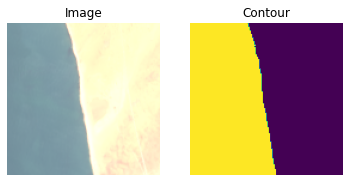

In [29]:
plot_rand(dataloaders)

In [31]:
def border_loss_iou(output,y,pool_size=(9,9), pad=(4,4)):
    y      = y.type(torch.float32)
    output = output.type(torch.float32)
    
    averaged_mask = F.avg_pool2d(y,kernel_size=pool_size,stride=(1,1), padding=pad)
    border = (averaged_mask>0.005).type(torch.float32) * (averaged_mask<0.995).type(torch.float32)
    weight = torch.ones_like(averaged_mask)
    w0     = torch.sum(weight)
    weight+= border*2
    w1     = torch.sum(weight)
    weight*= (w0/w1)
    loss   = weighted_bce_loss(output,y,weight) + weighted_dice_loss(output,y,weight) + iou_loss(output,y,weight)
    return loss

In [32]:
name = 'Multiscale UNET, WBCE + WDice + WIoU, NDWI Water Body'
loss_name= 'WBCE + WDice + WIoU'
model = UNET_multiscale2().to(device)
opt = optim.Adam(model.parameters(), lr=0.003)
scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[100,180], gamma=0.1)
history  = train(model, dataloaders, loss_fn = border_loss_iou, optimizer = opt, acc_fn = f1_score, epochs=50)

Epoch 1
[0.003]
Current step: 281, AllocMem (Mb): 440.792, Loss: 0.790,  F1: 0.881
Training complete in 1m 56s
----------


 Loss val: 0.649, F-Score val:0.913 


Training complete in 1m 59s
----------
Epoch 2
[0.003]
Current step: 281, AllocMem (Mb): 440.792, Loss: 0.501,  F1: 0.888
Training complete in 2m 0s
----------


 Loss val: 0.604, F-Score val:0.907 


Training complete in 2m 4s
----------
Epoch 3
[0.003]
Current step: 281, AllocMem (Mb): 440.792, Loss: 0.953,  F1: 0.893
Training complete in 2m 3s
----------


 Loss val: 0.585, F-Score val:0.916 


Training complete in 2m 6s
----------
Epoch 4
[0.003]
Current step: 281, AllocMem (Mb): 440.792, Loss: 0.677,  F1: 0.896
Training complete in 2m 3s
----------


 Loss val: 0.583, F-Score val:0.909 


Training complete in 2m 7s
----------
Epoch 5
[0.003]
Current step: 281, AllocMem (Mb): 440.792, Loss: 0.565,  F1: 0.900
Training complete in 2m 4s
----------


 Loss val: 0.589, F-Score val:0.913 


Training complete in 2m 7s
---------

Current step: 281, AllocMem (Mb): 440.792, Loss: 0.170,  F1: 0.987
Training complete in 2m 5s
----------


 Loss val: 0.112, F-Score val:0.989 


Training complete in 2m 8s
----------
Epoch 43
[0.003]
Current step: 281, AllocMem (Mb): 440.792, Loss: 0.071,  F1: 0.988
Training complete in 2m 5s
----------


 Loss val: 0.107, F-Score val:0.990 


Training complete in 2m 8s
----------
Epoch 44
[0.003]
Current step: 281, AllocMem (Mb): 440.792, Loss: 0.080,  F1: 0.987
Training complete in 2m 5s
----------


 Loss val: 0.133, F-Score val:0.986 


Training complete in 2m 8s
----------
Epoch 45
[0.003]
Current step: 281, AllocMem (Mb): 440.792, Loss: 0.082,  F1: 0.987
Training complete in 2m 4s
----------


 Loss val: 0.107, F-Score val:0.990 


Training complete in 2m 8s
----------
Epoch 46
[0.003]
Current step: 281, AllocMem (Mb): 440.792, Loss: 0.168,  F1: 0.987
Training complete in 2m 5s
----------


 Loss val: 0.125, F-Score val:0.989 


Training complete in 2m 8s
----------
Epoch 47
[0.

In [36]:
############### F-score and Save Model #################
# predictions = test_pred(model, X_test, batch_size=16)
# df = best_f_score('Multiscale UNET, WBCE + WDice + WIoU, JRC Monthly', Y_test[:,np.newaxis,:,:], predictions)
# df['Time'] = round(np.mean(history['Times']),2)
# thresh = df['Threshold'].iloc[0]
df.to_csv(csv_dir, mode='a')
torch.save({'Dataset'   : f'{dataset}_5K_2K_30m {name}',
            'Batch Size': batch_size,
            'Loss'      : loss_name,
            'Model'     : model,
            'F-score'   : df['F-Score'].values[0],
            'Time'      : round(np.mean(history['Times']),2),
            'Train Loss': history['Train Loss'],
            'Validation Loss': history['Valid Loss'],
            'Epochs'    : history['Epochs']},
          model_dir + '\\' + name +'.pth')
df.head()

,Name,Precision,Recall,IoU,F-Score,mF-Score,Threshold,True Negative Rate,False Positive Rate,AP,Time
45,"Multiscale UNET, WBCE + WDice + WIoU, JRC Monthly",0.9860401,0.98666143,0.9730689,0.98635066,0.9742949,0.8065,0.9801249,0.0198751,0.99901,125.8


In [37]:
################### F-score By Group ################
path = csv_dir.replace('F-scores.csv', 'F-scores_group.csv')
dict_f1 = {}
for key, list_ in zip(water_p_test.keys(),list_test_test):
    y_true= torch.from_numpy(Y_test[:,np.newaxis,:,:][list_])
    y_pred= torch.from_numpy(predictions[list_])
    dict_f1['Water'+key.split('Index')[-1]] = f1_score(y_pred.reshape(-1), y_true.reshape(-1), threshold=df['Threshold'].values[0])


df_f1 = pd.DataFrame.from_dict(dict_f1, orient='index')
df_f1 = pd.DataFrame(df_f1[0].rename('F1_score'))
df_f1 = df_f1.append(pd.Series(), ignore_index=True)
df_f1.index.names = [name]
df_f1.to_csv(path, mode='a')

C:\Users\SMOHA\AppData\Local\Temp/ipykernel_14656/2657704787.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_f1 = df_f1.append(pd.Series(), ignore_index=True)


In [39]:
preds = (predictions>thresh)*1.
preds = np.array([binary_dilation(mask)-mask for mask in preds ], dtype='float64')

In [40]:
################ Get Contours ##########################
Y_train = np.array([binary_dilation(mask)-mask for mask in Y_train ], dtype='float64')
Y_val   = np.array([binary_dilation(mask)-mask for mask in Y_val], dtype='float64')
Y_test  = np.array([binary_dilation(mask)-mask for mask in Y_test], dtype='float64')

In [41]:
df = best_f_score('Multiscale UNET, WBCE + WDice + WIoU, Dilation-mask', Y_test[:,np.newaxis,:,:], preds)
df.head()

,Name,Precision,Recall,IoU,F-Score,mF-Score,Threshold,True Negative Rate,False Positive Rate,AP
0,"Multiscale UNET, WBCE + WDice + WIoU, Dilation...",0.5307668288113349,0.619354379572433,0.40021595212999805,0.5716488967593784,0.6001727924519973,0.0,0.9940663626876386,0.005933637312361433,0.332813


In [43]:
#Load Data
X_train = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_train_4500_30m_res.npy")
X_val   = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_val_500_30m_res.npy")
X_test  = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_test_2000_30m_res.npy")

Y_train         = (X_train[...,1]-X_train[...,3])/(X_train[...,1]+X_train[...,3])
Y_val           = (X_val[...,1]-X_val[...,3])/(X_val[...,1]+X_val[...,3])
Y_test          = (X_test[...,1]-X_test[...,3])/(X_test[...,1]+X_test[...,3])

Y_train         = ((Y_train<1.)*1).astype('float32')
Y_val           = ((Y_val<1.)*1).astype('float32')
Y_test          = ((Y_test<1.)*1).astype('float32')

X_train         = X_train[...,2::-1].copy()
X_val           = X_val[...,2::-1].copy()
X_test          = X_test[...,2::-1].copy()

X_train         = X_train>>4
X_val           = X_val>>4
X_test          = X_test>>4

X_train         = X_train/2048.
X_val           = X_val/2048.
X_test          = X_test/2048.

# X_train         = X_train - X_train.min(axis=(1,2), keepdims=True) 
# X_val           = X_val  - X_val.min(axis=(1,2), keepdims=True)
# X_test          = X_test - X_test.min(axis=(1,2), keepdims=True) 

# X_train         = X_train / X_train.max(axis=(1,2), keepdims=True) 
# X_val           = X_val  / X_val.max(axis=(1,2), keepdims=True)
# X_test          = X_test / X_test.max(axis=(1,2), keepdims=True) 

C:\Users\SMOHA\AppData\Local\Temp/ipykernel_14656/187012830.py:6: RuntimeWarning: invalid value encountered in true_divide
  Y_train         = (X_train[...,1]-X_train[...,3])/(X_train[...,1]+X_train[...,3])
C:\Users\SMOHA\AppData\Local\Temp/ipykernel_14656/187012830.py:8: RuntimeWarning: invalid value encountered in true_divide
  Y_test          = (X_test[...,1]-X_test[...,3])/(X_test[...,1]+X_test[...,3])


In [44]:
predictions = test_pred(model, X_test, batch_size=16)
preds = (predictions>thresh)*1.
preds = np.array([mask-binary_erosion(mask) for mask in preds ], dtype='float64')

100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:12<00:00, 10.04it/s]


In [45]:
################ Get Contours ##########################
Y_train = np.array([mask-binary_erosion(mask) for mask in Y_train ], dtype='float64')
Y_val   = np.array([mask-binary_erosion(mask) for mask in Y_val], dtype='float64')
Y_test  = np.array([mask-binary_erosion(mask) for mask in Y_test], dtype='float64')

In [46]:
df = best_f_score('Multiscale UNET, WBCE + WDice + WIoU, mask-erosion', Y_test[:,np.newaxis,:,:], preds)
df.head()

,Name,Precision,Recall,IoU,F-Score,mF-Score,Threshold,True Negative Rate,False Positive Rate,AP
0,"Multiscale UNET, WBCE + WDice + WIoU, mask-ero...",0.5392271331758529,0.6244946993247474,0.40719916692808444,0.5787370778750534,0.6030839881320967,0.0,0.9942173984021334,0.005782601597866583,0.34077


## NIR

In [54]:
X_train = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_train_4500_30m_res.npy")
X_val   = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_val_500_30m_res.npy")
X_test  = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_test_2000_30m_res.npy")

Y_train         = (X_train[...,1]-X_train[...,3])/(X_train[...,1]+X_train[...,3])
Y_val           = (X_val[...,1]-X_val[...,3])/(X_val[...,1]+X_val[...,3])
Y_test          = (X_test[...,1]-X_test[...,3])/(X_test[...,1]+X_test[...,3])

Y_train         = ((Y_train<1.)*1).astype('float32')
Y_val           = ((Y_val<1.)*1).astype('float32')
Y_test          = ((Y_test<1.)*1).astype('float32')

X_train         = X_train[...,[2,1,0,3]].copy()
X_val           = X_val[...,[2,1,0,3]].copy()
X_test          = X_test[...,[2,1,0,3]].copy()

X_train         = X_train>>4
X_val           = X_val>>4
X_test          = X_test>>4

X_train         = X_train/1024.
X_val           = X_val/1024.
X_test          = X_test/1024.

# X_train         = X_train - X_train.min(axis=(1,2), keepdims=True) 
# X_val           = X_val  - X_val.min(axis=(1,2), keepdims=True)
# X_test          = X_test - X_test.min(axis=(1,2), keepdims=True) 

# X_train         = X_train / X_train.max(axis=(1,2), keepdims=True) 
# X_val           = X_val  / X_val.max(axis=(1,2), keepdims=True)
# X_test          = X_test / X_test.max(axis=(1,2), keepdims=True) 

C:\Users\SMOHA\AppData\Local\Temp/ipykernel_14656/3046078847.py:5: RuntimeWarning: invalid value encountered in true_divide
  Y_train         = (X_train[...,1]-X_train[...,3])/(X_train[...,1]+X_train[...,3])
C:\Users\SMOHA\AppData\Local\Temp/ipykernel_14656/3046078847.py:7: RuntimeWarning: invalid value encountered in true_divide
  Y_test          = (X_test[...,1]-X_test[...,3])/(X_test[...,1]+X_test[...,3])


In [55]:
# ################ Get Contours ##########################
# Y_train = np.array([binary_dilation(mask)-mask for mask in Y_train ], dtype='float64')
# Y_val   = np.array([binary_dilation(mask)-mask for mask in Y_val], dtype='float64')
# Y_test  = np.array([binary_dilation(mask)-mask for mask in Y_test], dtype='float64')

In [56]:
class NDWIDataset(Dataset):

    def __init__(self, images, masks, transform=None, test_transform=None):
        self.images     = images
        self.masks      = masks
        self.transforms = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transforms:
            augmentations = self.transforms(image=image, mask=mask)
        
        image = augmentations['image']
        mask  = augmentations['mask']
        mask  = mask[np.newaxis,:,:]
        
        return [image.type(torch.float32), 
                mask.type(torch.float32)]

In [57]:
def data(trans, trans_test, X_train, Y_train, X_val, Y_val, X_test, Y_test, split=0.9, val=True, batch_size=16):
    torch.manual_seed(49)
    random.seed(49)
    trainset= NDWIDataset(X_train, Y_train, transform=trans)

    if val:
        print(f'Training:{len(X_train)}, Validation:{len(X_val)}')
        print(f'Testing: {len(X_test)}')
        
        valset  = NDWIDataset(X_val, Y_val, transform=trans_test)
        testset = NDWIDataset(X_test, Y_test, transform=trans_test)
        image_datasets = {'train': trainset, 'val': valset, 'test': testset}
        batch_size = batch_size

        dataloaders = {
          'train': DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True, drop_last=True),#, num_workers=8),
          'val': DataLoader(valset, batch_size=batch_size, shuffle=True, pin_memory = True, drop_last=True),#, num_workers=8),
          'test': DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory = True, drop_last=True)#, num_workers=8)
        }
        
    else:
        print(f'Training:{len(X_train)}')
        print(f'Testing: {len(X_test)}')
        testset = NDWIDataset(X_test, Y_test, transform=trans_test)
        image_datasets = {'train': trainset, 'test': testset}
        batch_size = batch_size

        dataloaders = {
          'train': DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'test': DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory = True)#, num_workers=8)
        }
        
    
    return dataloaders

In [58]:
def border_loss_iou(output,y,pool_size=(9,9), pad=(4,4)):
    y      = y.type(torch.float32)
    output = output.type(torch.float32)
    
    averaged_mask = F.avg_pool2d(y,kernel_size=pool_size,stride=(1,1), padding=pad)
    border = (averaged_mask>0.005).type(torch.float32) * (averaged_mask<0.995).type(torch.float32)
    weight = torch.ones_like(averaged_mask)
    w0     = torch.sum(weight)
    weight+= border*2
    w1     = torch.sum(weight)
    weight*= (w0/w1)
    loss   = weighted_bce_loss(output,y,weight) + weighted_dice_loss(output,y,weight) + iou_loss(output,y,weight)
    return loss

In [59]:
batch_size = 16
dataloaders = data(trans, trans_test, X_train, Y_train, X_val, Y_val, X_test, Y_test, batch_size=batch_size)

Training:4500, Validation:500
Testing: 2000


In [90]:
name = 'Multiscale UNET, WBCE + WDice + WIoU, NIR, NDWI Water Body'
loss_name= 'WBCE + WDice + WIoU'
model = UNET_multiscale2(in_channels=4).to(device)
opt = optim.Adam(model.parameters(), lr=0.003)
scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[100,180], gamma=0.1)
history  = train(model, dataloaders, loss_fn = border_loss_iou, optimizer = opt, acc_fn = f1_score, epochs=50)

Epoch 1
[0.003]
Current step: 281, AllocMem (Mb): 536.136, Loss: 0.016,  F1: 0.991
Training complete in 1m 57s
----------


 Loss val: 0.029, F-Score val:0.999 


Training complete in 1m 60s
----------
Epoch 2
[0.003]
Current step: 281, AllocMem (Mb): 536.136, Loss: 0.048,  F1: 0.995
Training complete in 2m 2s
----------


 Loss val: 0.031, F-Score val:0.998 


Training complete in 2m 5s
----------
Epoch 3
[0.003]
Current step: 281, AllocMem (Mb): 536.136, Loss: 0.109,  F1: 0.997
Training complete in 2m 4s
----------


 Loss val: 0.017, F-Score val:0.999 


Training complete in 2m 7s
----------
Epoch 4
[0.003]
Current step: 281, AllocMem (Mb): 536.136, Loss: 0.047,  F1: 0.995
Training complete in 2m 5s
----------


 Loss val: 0.043, F-Score val:0.997 


Training complete in 2m 8s
----------
Epoch 5
[0.003]
Current step: 281, AllocMem (Mb): 536.136, Loss: 0.016,  F1: 0.997
Training complete in 2m 5s
----------


 Loss val: 0.015, F-Score val:0.999 


Training complete in 2m 8s
---------

Current step: 281, AllocMem (Mb): 536.136, Loss: 0.013,  F1: 0.999
Training complete in 2m 5s
----------


 Loss val: 0.009, F-Score val:1.000 


Training complete in 2m 8s
----------
Epoch 43
[0.003]
Current step: 281, AllocMem (Mb): 536.136, Loss: 0.019,  F1: 0.999
Training complete in 2m 5s
----------


 Loss val: 0.014, F-Score val:0.999 


Training complete in 2m 8s
----------
Epoch 44
[0.003]
Current step: 281, AllocMem (Mb): 536.136, Loss: 0.008,  F1: 0.999
Training complete in 2m 5s
----------


 Loss val: 0.009, F-Score val:1.000 


Training complete in 2m 8s
----------
Epoch 45
[0.003]
Current step: 281, AllocMem (Mb): 536.136, Loss: 0.014,  F1: 0.999
Training complete in 2m 5s
----------


 Loss val: 0.009, F-Score val:1.000 


Training complete in 2m 8s
----------
Epoch 46
[0.003]
Current step: 281, AllocMem (Mb): 536.136, Loss: 0.018,  F1: 0.999
Training complete in 2m 5s
----------


 Loss val: 0.008, F-Score val:1.000 


Training complete in 2m 8s
----------
Epoch 47
[0.

In [91]:
# ############### F-score and Save Model #################
predictions = test_pred(model, X_test, batch_size=16)
df = best_f_score(name, Y_test[:,np.newaxis,:,:], predictions)
df['Time'] = round(np.mean(history['Times']),2)
thresh = df['Threshold'].iloc[0]
df.to_csv(csv_dir, mode='a')
torch.save({'Dataset'   : f'{dataset}_5K_2K_30m {name}',
            'Batch Size': batch_size,
            'Loss'      : loss_name,
            'Model'     : model,
            'F-score'   : df['F-Score'].values[0],
            'Time'      : round(np.mean(history['Times']),2),
            'Train Loss': history['Train Loss'],
            'Validation Loss': history['Valid Loss'],
            'Epochs'    : history['Epochs']},
          model_dir + '\\' + name +'.pth')
df.head()

100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:14<00:00,  8.92it/s]


,Name,Precision,Recall,IoU,F-Score,mF-Score,Threshold,True Negative Rate,False Positive Rate,AP,Time
42,"Multiscale UNET, WBCE + WDice + WIoU, NIR, NDW...",0.9994865,0.99936134,0.9988484,0.9994239,0.99839187,0.315,0.9992695,0.0007305174,0.999999,126.24


In [92]:
################### F-score By Group ################
path = csv_dir.replace('F-scores.csv', 'F-scores_group.csv')
dict_f1 = {}
for key, list_ in zip(water_p_test.keys(),list_test_test):
    y_true= torch.from_numpy(Y_test[:,np.newaxis,:,:][list_])
    y_pred= torch.from_numpy(predictions[list_])
    dict_f1['Water'+key.split('Index')[-1]] = f1_score(y_pred.reshape(-1), y_true.reshape(-1), threshold=df['Threshold'].values[0])


df_f1 = pd.DataFrame.from_dict(dict_f1, orient='index')
df_f1 = pd.DataFrame(df_f1[0].rename('F1_score'))
df_f1 = df_f1.append(pd.Series(), ignore_index=True)
df_f1.index.names = [name]
df_f1.to_csv(path, mode='a')

C:\Users\SMOHA\AppData\Local\Temp/ipykernel_14656/2657704787.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_f1 = df_f1.append(pd.Series(), ignore_index=True)


In [93]:
from skimage.morphology import binary_erosion

In [94]:
preds = (predictions>thresh)*1.
preds = np.array([binary_dilation(mask)-mask for mask in preds ], dtype='float64')

In [95]:
################ Get Contours ##########################
Y_train = np.array([binary_dilation(mask)-mask for mask in Y_train ], dtype='float64')
Y_val   = np.array([binary_dilation(mask)-mask for mask in Y_val], dtype='float64')
Y_test  = np.array([binary_dilation(mask)-mask for mask in Y_test], dtype='float64')

In [96]:
df = best_f_score(name, Y_test[:,np.newaxis,:,:], preds)
df.head()

,Name,Precision,Recall,IoU,F-Score,mF-Score,Threshold,True Negative Rate,False Positive Rate,AP
0,"Multiscale UNET, WBCE + WDice + WIoU, NIR, NDW...",0.9450933549478834,0.9459677189786216,0.8966880376474652,0.945530334824763,0.9417604042935882,0.0,0.9994044429555005,0.0005955570444995806,0.894607


In [97]:
#Load Data
X_train = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_train_4500_30m_res.npy")
X_val   = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_val_500_30m_res.npy")
X_test  = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_test_2000_30m_res.npy")

Y_train         = (X_train[...,1]-X_train[...,3])/(X_train[...,1]+X_train[...,3])
Y_val           = (X_val[...,1]-X_val[...,3])/(X_val[...,1]+X_val[...,3])
Y_test          = (X_test[...,1]-X_test[...,3])/(X_test[...,1]+X_test[...,3])

Y_train         = ((Y_train<1.)*1).astype('float32')
Y_val           = ((Y_val<1.)*1).astype('float32')
Y_test          = ((Y_test<1.)*1).astype('float32')

X_train         = X_train[...,[2,1,0,3]].copy()
X_val           = X_val[...,[2,1,0,3]].copy()
X_test          = X_test[...,[2,1,0,3]].copy()

X_train         = X_train>>4
X_val           = X_val>>4
X_test          = X_test>>4

X_train         = X_train/2048.
X_val           = X_val/2048.
X_test          = X_test/2048.

# X_train         = X_train - X_train.min(axis=(1,2), keepdims=True) 
# X_val           = X_val  - X_val.min(axis=(1,2), keepdims=True)
# X_test          = X_test - X_test.min(axis=(1,2), keepdims=True) 

# X_train         = X_train / X_train.max(axis=(1,2), keepdims=True) 
# X_val           = X_val  / X_val.max(axis=(1,2), keepdims=True)
# X_test          = X_test / X_test.max(axis=(1,2), keepdims=True) 

C:\Users\SMOHA\AppData\Local\Temp/ipykernel_14656/915307426.py:6: RuntimeWarning: invalid value encountered in true_divide
  Y_train         = (X_train[...,1]-X_train[...,3])/(X_train[...,1]+X_train[...,3])
C:\Users\SMOHA\AppData\Local\Temp/ipykernel_14656/915307426.py:8: RuntimeWarning: invalid value encountered in true_divide
  Y_test          = (X_test[...,1]-X_test[...,3])/(X_test[...,1]+X_test[...,3])


In [98]:
preds = (predictions>thresh)*1.
preds = np.array([mask-binary_erosion(mask) for mask in preds ], dtype='float64')

In [99]:
################ Get Contours ##########################
Y_train = np.array([mask-binary_erosion(mask) for mask in Y_train ], dtype='float64')
Y_val   = np.array([mask-binary_erosion(mask) for mask in Y_val], dtype='float64')
Y_test  = np.array([mask-binary_erosion(mask) for mask in Y_test], dtype='float64')

In [100]:
df = best_f_score(name, Y_test[:,np.newaxis,:,:], preds)
df.head()

,Name,Precision,Recall,IoU,F-Score,mF-Score,Threshold,True Negative Rate,False Positive Rate,AP
0,"Multiscale UNET, WBCE + WDice + WIoU, NIR, NDW...",0.9470468373730033,0.946019654061194,0.8984932014264972,0.946532967040792,0.9423424372917986,0.0,0.9994268082117119,0.0005731917882880454,0.896504


# Contour Training mask-erosion

## RGB

In [103]:
X_train = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_train_4500_30m_res.npy")
X_val   = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_val_500_30m_res.npy")
X_test  = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_test_2000_30m_res.npy")

Y_train         = (X_train[...,1]-X_train[...,3])/(X_train[...,1]+X_train[...,3])
Y_val           = (X_val[...,1]-X_val[...,3])/(X_val[...,1]+X_val[...,3])
Y_test          = (X_test[...,1]-X_test[...,3])/(X_test[...,1]+X_test[...,3])

Y_train         = ((Y_train<1.)*1).astype('float32')
Y_val           = ((Y_val<1.)*1).astype('float32')
Y_test          = ((Y_test<1.)*1).astype('float32')

X_train         = X_train[...,2::-1].copy()
X_val           = X_val[...,2::-1].copy()
X_test          = X_test[...,2::-1].copy()

X_train         = X_train>>4
X_val           = X_val>>4
X_test          = X_test>>4

X_train         = X_train/2048.
X_val           = X_val/2048.
X_test          = X_test/2048.

# X_train         = X_train - X_train.min(axis=(1,2), keepdims=True) 
# X_val           = X_val  - X_val.min(axis=(1,2), keepdims=True)
# X_test          = X_test - X_test.min(axis=(1,2), keepdims=True) 

# X_train         = X_train / X_train.max(axis=(1,2), keepdims=True) 
# X_val           = X_val  / X_val.max(axis=(1,2), keepdims=True)
# X_test          = X_test / X_test.max(axis=(1,2), keepdims=True) 

C:\Users\SMOHA\AppData\Local\Temp/ipykernel_14656/2725039399.py:5: RuntimeWarning: invalid value encountered in true_divide
  Y_train         = (X_train[...,1]-X_train[...,3])/(X_train[...,1]+X_train[...,3])
C:\Users\SMOHA\AppData\Local\Temp/ipykernel_14656/2725039399.py:7: RuntimeWarning: invalid value encountered in true_divide
  Y_test          = (X_test[...,1]-X_test[...,3])/(X_test[...,1]+X_test[...,3])


In [104]:
#Get Metadata Sentinel
df = metadata(Y_train)
df_meta_train = pd.DataFrame.from_dict(df,orient='index')
print('Test Images:',len(df_meta_train))

#Get Metadata Landsat
df = metadata(Y_test)
df_meta_test = pd.DataFrame.from_dict(df,orient='index')
print('Test Images:',len(df_meta_test))

Test Images: 4500
Test Images: 2000


In [105]:
water_p_train = water_percentages(df_meta_train)
water_p_test = water_percentages(df_meta_test)

list_test_train = list_test(water_p_train)
list_test_test = list_test(water_p_test)

Index=0: 0
Index_10: 138
Index_20: 509
Index_30: 450
Index_40: 414
Index_50: 304
Index_60: 381
Index_70: 365
Index_80: 379
Index_90: 483
Index_99: 1077
Index=100: 0
Total Images: 4500
----------

Index=0: 0
Index_10: 59
Index_20: 215
Index_30: 204
Index_40: 185
Index_50: 149
Index_60: 173
Index_70: 181
Index_80: 155
Index_90: 199
Index_99: 480
Index=100: 0
Total Images: 2000
----------



In [106]:
################ Get Contours ##########################
Y_train = np.array([mask-binary_erosion(mask) for mask in Y_train ], dtype='float64')
Y_val   = np.array([mask-binary_erosion(mask) for mask in Y_val], dtype='float64')
Y_test  = np.array([mask-binary_erosion(mask) for mask in Y_test], dtype='float64')

In [107]:
batch_size = 16
dataloaders = data(trans, trans_test, X_train, Y_train, X_val, Y_val, X_test, Y_test, batch_size=batch_size)

Training:4500, Validation:500
Testing: 2000


In [108]:
def border_loss_iou(output,y,pool_size=(9,9), pad=(4,4)):
    y      = y.type(torch.float32)
    output = output.type(torch.float32)
    
    averaged_mask = F.avg_pool2d(y,kernel_size=pool_size,stride=(1,1), padding=pad)
    border = (averaged_mask>0.005).type(torch.float32) * (averaged_mask<0.995).type(torch.float32)
    weight = torch.ones_like(averaged_mask)
    w0     = torch.sum(weight)
    weight+= border*2
    w1     = torch.sum(weight)
    weight*= (w0/w1)
    loss   = weighted_bce_loss(output,y,weight) + weighted_dice_loss(output,y,weight) + iou_loss(output,y,weight)
    return loss

In [109]:
name = 'Multiscale UNET, WBCE + WDice + WIoU, NDWI, Contour Training'
loss_name= 'WBCE + WDice + WIoU'
model = UNET_multiscale2().to(device)
opt = optim.Adam(model.parameters(), lr=0.003)
scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[100,180], gamma=0.1)
history  = train(model, dataloaders, loss_fn = border_loss_iou, optimizer = opt, acc_fn = f1_score, epochs=50)

Epoch 1
[0.003]
Current step: 281, AllocMem (Mb): 533.199, Loss: 1.127,  F1: 0.382
Training complete in 1m 56s
----------


 Loss val: 1.182, F-Score val:0.509 


Training complete in 1m 59s
----------
Epoch 2
[0.003]
Current step: 281, AllocMem (Mb): 533.199, Loss: 0.888,  F1: 0.497
Training complete in 2m 1s
----------


 Loss val: 1.093, F-Score val:0.564 


Training complete in 2m 5s
----------
Epoch 3
[0.003]
Current step: 281, AllocMem (Mb): 533.199, Loss: 1.162,  F1: 0.526
Training complete in 2m 4s
----------


 Loss val: 1.051, F-Score val:0.558 


Training complete in 2m 7s
----------
Epoch 4
[0.003]
Current step: 281, AllocMem (Mb): 533.199, Loss: 1.158,  F1: 0.550
Training complete in 2m 5s
----------


 Loss val: 1.006, F-Score val:0.587 


Training complete in 2m 8s
----------
Epoch 5
[0.003]
Current step: 281, AllocMem (Mb): 533.199, Loss: 0.994,  F1: 0.575
Training complete in 2m 5s
----------


 Loss val: 1.002, F-Score val:0.591 


Training complete in 2m 8s
---------

Current step: 281, AllocMem (Mb): 529.136, Loss: 0.819,  F1: 0.739
Training complete in 2m 5s
----------


 Loss val: 0.743, F-Score val:0.717 


Training complete in 2m 8s
----------
Epoch 43
[0.003]
Current step: 281, AllocMem (Mb): 529.136, Loss: 0.665,  F1: 0.739
Training complete in 2m 5s
----------


 Loss val: 0.747, F-Score val:0.721 


Training complete in 2m 9s
----------
Epoch 44
[0.003]
Current step: 281, AllocMem (Mb): 529.136, Loss: 0.611,  F1: 0.740
Training complete in 2m 5s
----------


 Loss val: 0.727, F-Score val:0.725 


Training complete in 2m 8s
----------
Epoch 45
[0.003]
Current step: 281, AllocMem (Mb): 529.136, Loss: 0.630,  F1: 0.742
Training complete in 2m 5s
----------


 Loss val: 0.742, F-Score val:0.726 


Training complete in 2m 9s
----------
Epoch 46
[0.003]
Current step: 281, AllocMem (Mb): 529.136, Loss: 0.642,  F1: 0.742
Training complete in 2m 5s
----------


 Loss val: 0.780, F-Score val:0.709 


Training complete in 2m 9s
----------
Epoch 47
[0.

In [110]:
############### F-score and Save Model #################
predictions = test_pred(model, X_test, batch_size=16)
df = best_f_score(name, Y_test[:,np.newaxis,:,:], predictions)
df['Time'] = round(np.mean(history['Times']),2)
df.to_csv(csv_dir, mode='a')
torch.save({'Dataset'   : f'{dataset}_5K_2K_30m {name}',
            'Batch Size': batch_size,
            'Loss'      : loss_name,
            'Model'     : model,
            'F-score'   : df['F-Score'].values[0],
            'Time'      : round(np.mean(history['Times']),2),
            'Train Loss': history['Train Loss'],
            'Validation Loss': history['Valid Loss'],
            'Epochs'    : history['Epochs']},
          model_dir + '\\' + name +'.pth')
df.head()

100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:14<00:00,  8.91it/s]


,Name,Precision,Recall,IoU,F-Score,mF-Score,Threshold,True Negative Rate,False Positive Rate,AP,Time
42,"Multiscale UNET, WBCE + WDice + WIoU, NDWI, Co...",0.7047553507402537,0.7492484542069484,0.5702545413575539,0.7263211490088018,0.7122436116124921,0.675,0.9965986692547958,0.003401330745204235,0.773529,126.44


In [111]:
################### F-score By Group ################
path = csv_dir.replace('F-scores.csv', 'F-scores_group.csv')
dict_f1 = {}
for key, list_ in zip(water_p_test.keys(),list_test_test):
    y_true= torch.from_numpy(Y_test[:,np.newaxis,:,:][list_])
    y_pred= torch.from_numpy(predictions[list_])
    dict_f1['Water'+key.split('Index')[-1]] = f1_score(y_pred.reshape(-1), y_true.reshape(-1), threshold=df['Threshold'].values[0])


df_f1 = pd.DataFrame.from_dict(dict_f1, orient='index')
df_f1 = pd.DataFrame(df_f1[0].rename('F1_score'))
df_f1 = df_f1.append(pd.Series(), ignore_index=True)
df_f1.index.names = [name]
df_f1.to_csv(path, mode='a')

C:\Users\SMOHA\AppData\Local\Temp/ipykernel_14656/2657704787.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_f1 = df_f1.append(pd.Series(), ignore_index=True)


## RGBIR

In [113]:
X_train = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_train_4500_30m_res.npy")
X_val   = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_val_500_30m_res.npy")
X_test  = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_test_2000_30m_res.npy")

Y_train         = (X_train[...,1]-X_train[...,3])/(X_train[...,1]+X_train[...,3])
Y_val           = (X_val[...,1]-X_val[...,3])/(X_val[...,1]+X_val[...,3])
Y_test          = (X_test[...,1]-X_test[...,3])/(X_test[...,1]+X_test[...,3])

Y_train         = ((Y_train<1.)*1).astype('float32')
Y_val           = ((Y_val<1.)*1).astype('float32')
Y_test          = ((Y_test<1.)*1).astype('float32')

X_train         = X_train[...,[2,1,0,3]].copy()
X_val           = X_val[...,[2,1,0,3]].copy()
X_test          = X_test[...,[2,1,0,3]].copy()

X_train         = X_train>>4
X_val           = X_val>>4
X_test          = X_test>>4

X_train         = X_train/2048.
X_val           = X_val/2048.
X_test          = X_test/2048.

# X_train         = X_train - X_train.min(axis=(1,2), keepdims=True) 
# X_val           = X_val  - X_val.min(axis=(1,2), keepdims=True)
# X_test          = X_test - X_test.min(axis=(1,2), keepdims=True) 

# X_train         = X_train / X_train.max(axis=(1,2), keepdims=True) 
# X_val           = X_val  / X_val.max(axis=(1,2), keepdims=True)
# X_test          = X_test / X_test.max(axis=(1,2), keepdims=True) 

C:\Users\SMOHA\AppData\Local\Temp/ipykernel_14656/3475169157.py:5: RuntimeWarning: invalid value encountered in true_divide
  Y_train         = (X_train[...,1]-X_train[...,3])/(X_train[...,1]+X_train[...,3])
C:\Users\SMOHA\AppData\Local\Temp/ipykernel_14656/3475169157.py:7: RuntimeWarning: invalid value encountered in true_divide
  Y_test          = (X_test[...,1]-X_test[...,3])/(X_test[...,1]+X_test[...,3])


In [114]:
#Get Metadata Sentinel
df = metadata(Y_train)
df_meta_train = pd.DataFrame.from_dict(df,orient='index')
print('Test Images:',len(df_meta_train))

#Get Metadata Landsat
df = metadata(Y_test)
df_meta_test = pd.DataFrame.from_dict(df,orient='index')
print('Test Images:',len(df_meta_test))

Test Images: 4500
Test Images: 2000


In [115]:
water_p_train = water_percentages(df_meta_train)
water_p_test = water_percentages(df_meta_test)

list_test_train = list_test(water_p_train)
list_test_test = list_test(water_p_test)

Index=0: 0
Index_10: 138
Index_20: 509
Index_30: 450
Index_40: 414
Index_50: 304
Index_60: 381
Index_70: 365
Index_80: 379
Index_90: 483
Index_99: 1077
Index=100: 0
Total Images: 4500
----------

Index=0: 0
Index_10: 59
Index_20: 215
Index_30: 204
Index_40: 185
Index_50: 149
Index_60: 173
Index_70: 181
Index_80: 155
Index_90: 199
Index_99: 480
Index=100: 0
Total Images: 2000
----------



In [116]:
################ Get Contours ##########################
Y_train = np.array([mask-binary_erosion(mask) for mask in Y_train ], dtype='float64')
Y_val   = np.array([mask-binary_erosion(mask) for mask in Y_val], dtype='float64')
Y_test  = np.array([mask-binary_erosion(mask) for mask in Y_test], dtype='float64')

In [117]:
batch_size = 16
dataloaders = data(trans, trans_test, X_train, Y_train, X_val, Y_val, X_test, Y_test, batch_size=batch_size)

Training:4500, Validation:500
Testing: 2000


In [118]:
def border_loss_iou(output,y,pool_size=(9,9), pad=(4,4)):
    y      = y.type(torch.float32)
    output = output.type(torch.float32)
    
    averaged_mask = F.avg_pool2d(y,kernel_size=pool_size,stride=(1,1), padding=pad)
    border = (averaged_mask>0.005).type(torch.float32) * (averaged_mask<0.995).type(torch.float32)
    weight = torch.ones_like(averaged_mask)
    w0     = torch.sum(weight)
    weight+= border*2
    w1     = torch.sum(weight)
    weight*= (w0/w1)
    loss   = weighted_bce_loss(output,y,weight) + weighted_dice_loss(output,y,weight) + iou_loss(output,y,weight)
    return loss

In [119]:
name = 'Multiscale UNET, WBCE + WDice + WIoU, NDWI, Contour Training, RGBIR'
loss_name= 'WBCE + WDice + WIoU'
model = UNET_multiscale2(in_channels=4).to(device)
opt = optim.Adam(model.parameters(), lr=0.003)
scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[100,180], gamma=0.1)
history  = train(model, dataloaders, loss_fn = border_loss_iou, optimizer = opt, acc_fn = f1_score, epochs=50)

Epoch 1
[0.003]
Current step: 281, AllocMem (Mb): 531.636, Loss: 0.155,  F1: 0.779
Training complete in 1m 56s
----------


 Loss val: 0.237, F-Score val:0.927 


Training complete in 1m 59s
----------
Epoch 2
[0.003]
Current step: 281, AllocMem (Mb): 531.636, Loss: 0.276,  F1: 0.873
Training complete in 2m 2s
----------


 Loss val: 0.236, F-Score val:0.924 


Training complete in 2m 6s
----------
Epoch 3
[0.003]
Current step: 281, AllocMem (Mb): 531.636, Loss: 0.816,  F1: 0.884
Training complete in 2m 5s
----------


 Loss val: 0.201, F-Score val:0.937 


Training complete in 2m 8s
----------
Epoch 4
[0.003]
Current step: 281, AllocMem (Mb): 531.636, Loss: 0.237,  F1: 0.886
Training complete in 2m 5s
----------


 Loss val: 0.258, F-Score val:0.917 


Training complete in 2m 9s
----------
Epoch 5
[0.003]
Current step: 281, AllocMem (Mb): 531.636, Loss: 0.271,  F1: 0.899
Training complete in 2m 5s
----------


 Loss val: 0.218, F-Score val:0.930 


Training complete in 2m 9s
---------

Current step: 281, AllocMem (Mb): 531.636, Loss: 0.137,  F1: 0.937
Training complete in 2m 6s
----------


 Loss val: 0.170, F-Score val:0.946 


Training complete in 2m 9s
----------
Epoch 43
[0.003]
Current step: 281, AllocMem (Mb): 531.636, Loss: 0.277,  F1: 0.936
Training complete in 2m 6s
----------


 Loss val: 0.200, F-Score val:0.937 


Training complete in 2m 9s
----------
Epoch 44
[0.003]
Current step: 281, AllocMem (Mb): 531.636, Loss: 0.121,  F1: 0.941
Training complete in 2m 6s
----------


 Loss val: 0.119, F-Score val:0.964 


Training complete in 2m 9s
----------
Epoch 45
[0.003]
Current step: 281, AllocMem (Mb): 531.636, Loss: 0.117,  F1: 0.939
Training complete in 2m 6s
----------


 Loss val: 0.130, F-Score val:0.959 


Training complete in 2m 9s
----------
Epoch 46
[0.003]
Current step: 281, AllocMem (Mb): 531.636, Loss: 0.196,  F1: 0.942
Training complete in 2m 6s
----------


 Loss val: 0.104, F-Score val:0.969 


Training complete in 2m 9s
----------
Epoch 47
[0.

In [120]:
############### F-score and Save Model #################
predictions = test_pred(model, X_test, batch_size=16)
df = best_f_score(name, Y_test[:,np.newaxis,:,:], predictions)
df['Time'] = round(np.mean(history['Times']),2)
df.to_csv(csv_dir, mode='a')
torch.save({'Dataset'   : f'{dataset}_5K_2K_30m {name}',
            'Batch Size': batch_size,
            'Loss'      : loss_name,
            'Model'     : model,
            'F-score'   : df['F-Score'].values[0],
            'Time'      : round(np.mean(history['Times']),2),
            'Train Loss': history['Train Loss'],
            'Validation Loss': history['Valid Loss'],
            'Epochs'    : history['Epochs']},
          model_dir + '\\' + name +'.pth')
df.head()

100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:14<00:00,  8.75it/s]


,Name,Precision,Recall,IoU,F-Score,mF-Score,Threshold,True Negative Rate,False Positive Rate,AP,Time
48,"Multiscale UNET, WBCE + WDice + WIoU, NDWI, Co...",0.9446809234204874,0.9489461278311072,0.898990280369799,0.9468087221538961,0.9392464736096094,0.428,0.9993978416819664,0.0006021583180336174,0.990564,127.41


In [121]:
################### F-score By Group ################
path = csv_dir.replace('F-scores.csv', 'F-scores_group.csv')
dict_f1 = {}
for key, list_ in zip(water_p_test.keys(),list_test_test):
    y_true= torch.from_numpy(Y_test[:,np.newaxis,:,:][list_])
    y_pred= torch.from_numpy(predictions[list_])
    dict_f1['Water'+key.split('Index')[-1]] = f1_score(y_pred.reshape(-1), y_true.reshape(-1), threshold=df['Threshold'].values[0])


df_f1 = pd.DataFrame.from_dict(dict_f1, orient='index')
df_f1 = pd.DataFrame(df_f1[0].rename('F1_score'))
df_f1 = df_f1.append(pd.Series(), ignore_index=True)
df_f1.index.names = [name]
df_f1.to_csv(path, mode='a')

C:\Users\SMOHA\AppData\Local\Temp/ipykernel_14656/2657704787.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_f1 = df_f1.append(pd.Series(), ignore_index=True)


# Contour Training Dilation-mask

## RGB

In [ ]:
X_train = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_train_4500_30m_res.npy")
X_val   = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_val_500_30m_res.npy")
X_test  = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_test_2000_30m_res.npy")

Y_train         = (X_train[...,1]-X_train[...,3])/(X_train[...,1]+X_train[...,3])
Y_val           = (X_val[...,1]-X_val[...,3])/(X_val[...,1]+X_val[...,3])
Y_test          = (X_test[...,1]-X_test[...,3])/(X_test[...,1]+X_test[...,3])

Y_train         = ((Y_train<1.)*1).astype('float32')
Y_val           = ((Y_val<1.)*1).astype('float32')
Y_test          = ((Y_test<1.)*1).astype('float32')

X_train         = X_train[...,2::-1].copy()
X_val           = X_val[...,2::-1].copy()
X_test          = X_test[...,2::-1].copy()

X_train         = X_train>>4
X_val           = X_val>>4
X_test          = X_test>>4

X_train         = X_train/2048.
X_val           = X_val/2048.
X_test          = X_test/2048.

# X_train         = X_train - X_train.min(axis=(1,2), keepdims=True) 
# X_val           = X_val  - X_val.min(axis=(1,2), keepdims=True)
# X_test          = X_test - X_test.min(axis=(1,2), keepdims=True) 

# X_train         = X_train / X_train.max(axis=(1,2), keepdims=True) 
# X_val           = X_val  / X_val.max(axis=(1,2), keepdims=True)
# X_test          = X_test / X_test.max(axis=(1,2), keepdims=True) 

In [ ]:
#Get Metadata Sentinel
df = metadata(Y_train)
df_meta_train = pd.DataFrame.from_dict(df,orient='index')
print('Test Images:',len(df_meta_train))

#Get Metadata Landsat
df = metadata(Y_test)
df_meta_test = pd.DataFrame.from_dict(df,orient='index')
print('Test Images:',len(df_meta_test))

In [ ]:
water_p_train = water_percentages(df_meta_train)
water_p_test = water_percentages(df_meta_test)

list_test_train = list_test(water_p_train)
list_test_test = list_test(water_p_test)

In [ ]:
################ Get Contours ##########################
Y_train = np.array([binary_dilation(mask)-mask for mask in Y_train ], dtype='float64')
Y_val   = np.array([binary_dilation(mask)-mask for mask in Y_val], dtype='float64')
Y_test  = np.array([binary_dilation(mask)-mask for mask in Y_test], dtype='float64')

In [ ]:
batch_size = 16
dataloaders = data(trans, trans_test, X_train, Y_train, X_val, Y_val, X_test, Y_test, batch_size=batch_size)

In [ ]:
def border_loss_iou(output,y,pool_size=(9,9), pad=(4,4)):
    y      = y.type(torch.float32)
    output = output.type(torch.float32)
    
    averaged_mask = F.avg_pool2d(y,kernel_size=pool_size,stride=(1,1), padding=pad)
    border = (averaged_mask>0.005).type(torch.float32) * (averaged_mask<0.995).type(torch.float32)
    weight = torch.ones_like(averaged_mask)
    w0     = torch.sum(weight)
    weight+= border*2
    w1     = torch.sum(weight)
    weight*= (w0/w1)
    loss   = weighted_bce_loss(output,y,weight) + weighted_dice_loss(output,y,weight) + iou_loss(output,y,weight)
    return loss

In [ ]:
name = 'Multiscale UNET, WBCE + WDice + WIoU, NDWI, RGB Contour Training, Diltion-mask'
loss_name= 'WBCE + WDice + WIoU'
model = UNET_multiscale2().to(device)
opt = optim.Adam(model.parameters(), lr=0.003)
scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[100,180], gamma=0.1)
history  = train(model, dataloaders, loss_fn = border_loss_iou, optimizer = opt, acc_fn = f1_score, epochs=50)

In [ ]:
############### F-score and Save Model #################
predictions = test_pred(model, X_test, batch_size=16)
df = best_f_score(name, Y_test[:,np.newaxis,:,:], predictions)
df['Time'] = round(np.mean(history['Times']),2)
df.to_csv(csv_dir, mode='a')
torch.save({'Dataset'   : f'{dataset}_5K_2K_30m {name}',
            'Batch Size': batch_size,
            'Loss'      : loss_name,
            'Model'     : model,
            'F-score'   : df['F-Score'].values[0],
            'Time'      : round(np.mean(history['Times']),2),
            'Train Loss': history['Train Loss'],
            'Validation Loss': history['Valid Loss'],
            'Epochs'    : history['Epochs']},
          model_dir + '\\' + name +'.pth')
df.head()

In [ ]:
################### F-score By Group ################
path = csv_dir.replace('F-scores.csv', 'F-scores_group.csv')
dict_f1 = {}
for key, list_ in zip(water_p_test.keys(),list_test_test):
    y_true= torch.from_numpy(Y_test[:,np.newaxis,:,:][list_])
    y_pred= torch.from_numpy(predictions[list_])
    dict_f1['Water'+key.split('Index')[-1]] = f1_score(y_pred.reshape(-1), y_true.reshape(-1), threshold=df['Threshold'].values[0])


df_f1 = pd.DataFrame.from_dict(dict_f1, orient='index')
df_f1 = pd.DataFrame(df_f1[0].rename('F1_score'))
df_f1 = df_f1.append(pd.Series(), ignore_index=True)
df_f1.index.names = [name]
df_f1.to_csv(path, mode='a')

## RGBIR

In [ ]:
X_train = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_train_4500_30m_res.npy")
X_val   = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_val_500_30m_res.npy")
X_test  = np.load(r"C:\Users\SMOHA\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_test_2000_30m_res.npy")

Y_train         = (X_train[...,1]-X_train[...,3])/(X_train[...,1]+X_train[...,3])
Y_val           = (X_val[...,1]-X_val[...,3])/(X_val[...,1]+X_val[...,3])
Y_test          = (X_test[...,1]-X_test[...,3])/(X_test[...,1]+X_test[...,3])

Y_train         = ((Y_train<1.)*1).astype('float32')
Y_val           = ((Y_val<1.)*1).astype('float32')
Y_test          = ((Y_test<1.)*1).astype('float32')

X_train         = X_train[...,[2,1,0,3]].copy()
X_val           = X_val[...,[2,1,0,3]].copy()
X_test          = X_test[...,[2,1,0,3]].copy()

X_train         = X_train>>4
X_val           = X_val>>4
X_test          = X_test>>4

X_train         = X_train/2048.
X_val           = X_val/2048.
X_test          = X_test/2048.

# X_train         = X_train - X_train.min(axis=(1,2), keepdims=True) 
# X_val           = X_val  - X_val.min(axis=(1,2), keepdims=True)
# X_test          = X_test - X_test.min(axis=(1,2), keepdims=True) 

# X_train         = X_train / X_train.max(axis=(1,2), keepdims=True) 
# X_val           = X_val  / X_val.max(axis=(1,2), keepdims=True)
# X_test          = X_test / X_test.max(axis=(1,2), keepdims=True) 

In [ ]:
#Get Metadata Sentinel
df = metadata(Y_train)
df_meta_train = pd.DataFrame.from_dict(df,orient='index')
print('Test Images:',len(df_meta_train))

#Get Metadata Landsat
df = metadata(Y_test)
df_meta_test = pd.DataFrame.from_dict(df,orient='index')
print('Test Images:',len(df_meta_test))

In [ ]:
water_p_train = water_percentages(df_meta_train)
water_p_test = water_percentages(df_meta_test)

list_test_train = list_test(water_p_train)
list_test_test = list_test(water_p_test)

In [ ]:
################ Get Contours ##########################
Y_train = np.array([binary_dilation(mask)-mask for mask in Y_train ], dtype='float64')
Y_val   = np.array([binary_dilation(mask)-mask for mask in Y_val], dtype='float64')
Y_test  = np.array([binary_dilation(mask)-mask for mask in Y_test], dtype='float64')

In [ ]:
batch_size = 16
dataloaders = data(trans, trans_test, X_train, Y_train, X_val, Y_val, X_test, Y_test, batch_size=batch_size)

In [ ]:
def border_loss_iou(output,y,pool_size=(9,9), pad=(4,4)):
    y      = y.type(torch.float32)
    output = output.type(torch.float32)
    
    averaged_mask = F.avg_pool2d(y,kernel_size=pool_size,stride=(1,1), padding=pad)
    border = (averaged_mask>0.005).type(torch.float32) * (averaged_mask<0.995).type(torch.float32)
    weight = torch.ones_like(averaged_mask)
    w0     = torch.sum(weight)
    weight+= border*2
    w1     = torch.sum(weight)
    weight*= (w0/w1)
    loss   = weighted_bce_loss(output,y,weight) + weighted_dice_loss(output,y,weight) + iou_loss(output,y,weight)
    return loss

In [ ]:
name = 'Multiscale UNET, WBCE + WDice + WIoU, NDWI, Contour Training, RGBIR, Dilation-mask'
loss_name= 'WBCE + WDice + WIoU'
model = UNET_multiscale2(in_channels=4).to(device)
opt = optim.Adam(model.parameters(), lr=0.003)
scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[100,180], gamma=0.1)
history  = train(model, dataloaders, loss_fn = border_loss_iou, optimizer = opt, acc_fn = f1_score, epochs=50)

In [ ]:
############### F-score and Save Model #################
predictions = test_pred(model, X_test, batch_size=16)
df = best_f_score(name, Y_test[:,np.newaxis,:,:], predictions)
df['Time'] = round(np.mean(history['Times']),2)
df.to_csv(csv_dir, mode='a')
torch.save({'Dataset'   : f'{dataset}_5K_2K_30m {name}',
            'Batch Size': batch_size,
            'Loss'      : loss_name,
            'Model'     : model,
            'F-score'   : df['F-Score'].values[0],
            'Time'      : round(np.mean(history['Times']),2),
            'Train Loss': history['Train Loss'],
            'Validation Loss': history['Valid Loss'],
            'Epochs'    : history['Epochs']},
          model_dir + '\\' + name +'.pth')
df.head()

In [ ]:
################### F-score By Group ################
path = csv_dir.replace('F-scores.csv', 'F-scores_group.csv')
dict_f1 = {}
for key, list_ in zip(water_p_test.keys(),list_test_test):
    y_true= torch.from_numpy(Y_test[:,np.newaxis,:,:][list_])
    y_pred= torch.from_numpy(predictions[list_])
    dict_f1['Water'+key.split('Index')[-1]] = f1_score(y_pred.reshape(-1), y_true.reshape(-1), threshold=df['Threshold'].values[0])


df_f1 = pd.DataFrame.from_dict(dict_f1, orient='index')
df_f1 = pd.DataFrame(df_f1[0].rename('F1_score'))
df_f1 = df_f1.append(pd.Series(), ignore_index=True)
df_f1.index.names = [name]
df_f1.to_csv(path, mode='a')